In [1]:
import os
import re
import sys
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import multiprocessing.pool
import fnmatch
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
from scipy import signal, ndimage
from natsort import natsorted
import seaborn as sns

import mgen
import datasetmaker
import shared as sd
import loaders as ld
import vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
from F_utils import *
print(generator_2)
print(f'Python: {sys.prefix}')

<function generator_2 at 0x7fd89f6e95e0>
Python: /home/plotnips/anaconda3/envs/torch2


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    'savefig.dpi': 100,  # to adjust notebook inline plot size
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
root_fwi = './out_ac/'
root_out = '/data/oleg/data/'
root_field = os.path.join('./data_cgg/')
nmodels = 16
# benchmark_marm = True

In [4]:
#     cmap = 'gist_ncar'
from functools import partial
def unpack_file(NAME):
    pts=NAME.split('/')
    f_name=pts[-1]
    f_name=f_name[:-4]; 
    # print('reading ',f_name)
    with open(NAME, 'rb') as f:
        data=np.load(f)
        model=data['models'].squeeze()
        initial_model=data['models_init'].squeeze()
        input_data=data['input_data'].squeeze()
        output_data=data['output_data'].squeeze()
        input_data_real_amplitudes=data['input_data_real_amplitudes'].squeeze()
        output_data_real_amplitudes=data['output_data_real_amplitudes'].squeeze()
        data.close()
    fwi_result=input_data_real_amplitudes+initial_model
    data_structure={'model':model.T,'initial_model':initial_model.T,'input_data':input_data.T,'input_data_real_amplitudes':input_data_real_amplitudes.T
        ,'output_data_real_amplitudes':output_data_real_amplitudes.T,'name':f_name,'output_data':output_data.T,'fwi_result':fwi_result.T}
    # Plot_image(M0.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M0',Aspect='equal')
    # Plot_image(M2.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M2',Aspect='equal')
    return data_structure
def extract_structure_field(list_of_structures,field):
    list_of_arrays=[]
    for i in range(len(list_of_structures)):
        list_of_arrays.append( list_of_structures[i][field] )
    return list_of_arrays
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True
def divmax(x): return x / np.max(np.abs(x))  
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp
def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax
def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 
def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x
def plot_log_model(mm, dx, nx, nz0, _src):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca();
    map_src = _src.x / dx < nx
    plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    cmap='RdBu_r'
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000, 0, nz0 * dx/1000], 
                   origin='upper', vmin=1.45, vmax=3.5); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label('km/s');
    ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(f); ax.invert_yaxis();

    log = model_log.vp[:, log_idx]
    vh = 420*dx * np.ones_like(log)/ 1000 
    ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
    ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
    plt.pause(0.001)
def make_vp_vs_rho(vp,taper):
    # taper=-taper+1
    vs = vp.copy() / (3 ** 0.5)
    # taper = vp < 1.01 * np.min(vp)
    vs = np.where(taper, 0, vs)
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(taper, 1000, rho)
    return vp, vs, rho

# Velocity models dataset

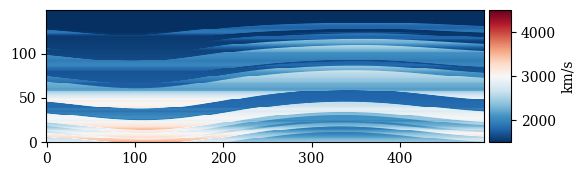

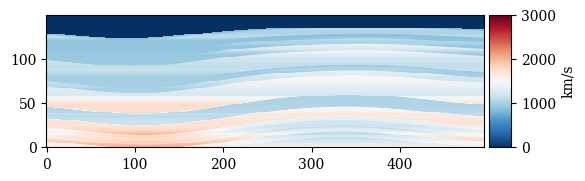

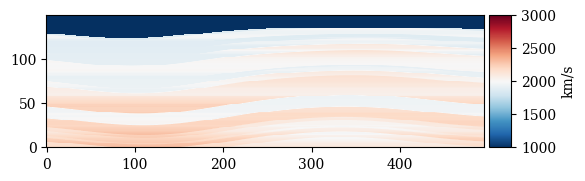

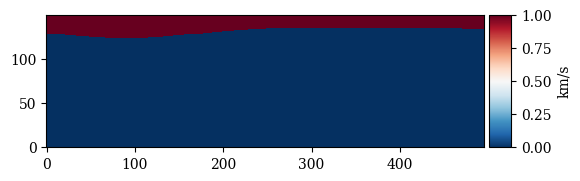

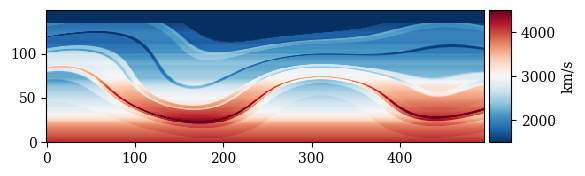

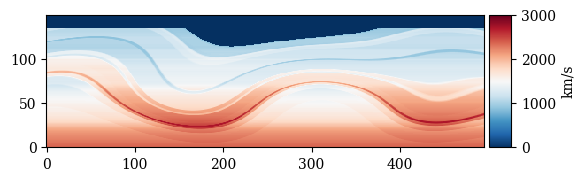

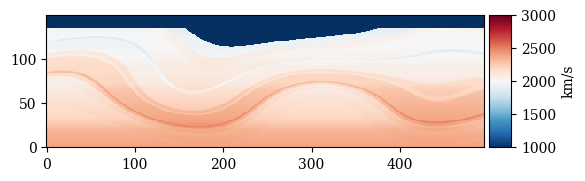

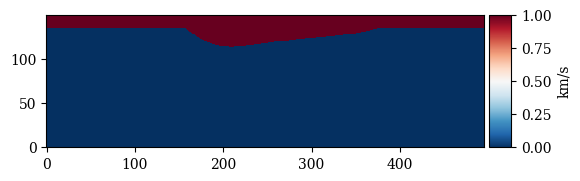

In [18]:
for i in range(2):
    # print(i)
    calculation_spacing=25
    generator_to_use=generator_2
    pars={'dx': calculation_spacing, 'dz': calculation_spacing,'out_shape':[496,150] ,'dsrc':200 } 
    number=0;model_name='model_'+str(number)
    generated_model,initial_model,water_taper=generator_to_use('oleg',model_name,dh=calculation_spacing,out_shape=pars['out_shape'])
    vp, vs, rho=make_vp_vs_rho(generated_model,water_taper)

    # print(water_taper)
    # print(water_taper.min(),water_taper.max())
    # print(vp.min(),vp.max())
    # print(vs.min(),vs.max())
    # print(rho.min(),rho.max())
    # print(generated_model.shape)
    # vis.plot_model(np.fliplr(generated_model).T,clim=[1500,4500])
    vis.plot_model(np.fliplr(vp).T,clim=[1500,4500])
    vis.plot_model(np.fliplr(vs).T,clim=[0,3000])
    vis.plot_model(np.fliplr(rho).T,clim=[1000,3000])
    vis.plot_model(np.fliplr(water_taper).T)
    # print((np.fliplr(generated_model).T).shape)

In [11]:
from F_utils import *
def _get_model(imodel):
    model_name='model_'+str(imodel)
    generated_model,initial_model,water_taper=generator_to_use('oleg',model_name,dh=calculation_spacing,out_shape=pars['out_shape'])
    return generated_model,initial_model,water_taper
path_save_rand_models = os.path.join(os.getcwd(), 'rand_models.npy')
nmodels=1000
if not os.path.exists(path_save_rand_models):
    num_cores = multiprocessing.cpu_count() // 2

    print('Start parallel pool for model generation...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_cores) as pool:
        other_models_ = pool.starmap(_get_model, zip(model_ids))
    print(f'OK, {time.time() - t1} sec')
else:
    print(f'Load random models from {path_save_rand_models}...', end='')
    # loaded = np.load(path_save_rand_models)
    # other_models = [loaded[i, ...] for i in range(loaded.shape[0])]
# print(len(other_models), other_models[0].shape)


Start parallel pool for model generation...OK, 20.83229923248291 sec


In [12]:
print(len(other_models_))
print((other_models_[0][0].shape))
other_models=[]
other_models_init=[]
for model in other_models_:
    other_models.append(model[0])
    other_models_init.append(model[1])
    
print(len(other_models))
print((other_models[4].shape))

1000
(496, 150)
1000
(496, 150)


(496, 150)


No handles with labels found to put in legend.


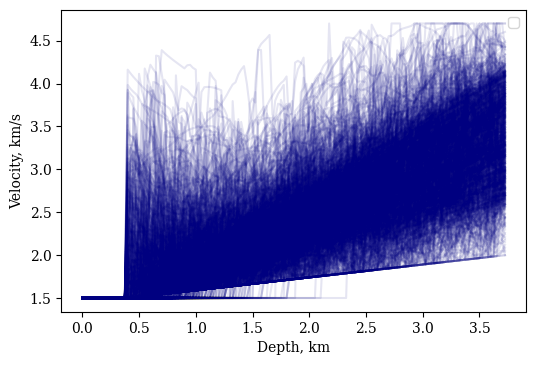

In [16]:
# Lines
# importlib.reload(vis)
log_idx=100;dx=25
# true_log = model_init.vp[::-1, log_idx] / 1000
print(other_models[0].shape)
for imodel in range(nmodels-1):
# for imodel in range(2):
    log = other_models[imodel][log_idx,:] / 1000
    xax = dx * np.arange(len(log)) / 1000
    plt.plot(xax, log, 'navy', alpha=0.1)
# log = other_models[nmodels-1][::-1, log_idx] / 1000
# plt.plot(xax, log, 'navy', alpha=0.1, label='Train')

# Vertical profile
# loc_dist = 1.75
# idx_dist = int(loc_dist * 1000 / dx)
# plt.plot(np.ones_like(xax) * loc_dist, 
#          box_min/1000 + np.linspace(0, 1, len(xax)) * (box_max - box_min)/1000, 
#          'w--', lw=2)

# Mean profile
# plt.plot(xax, true_log, 'w', lw=6)
# plt.plot(xax, true_log, 'k--', lw=2, label='Init')
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s'); plt.legend();
# vis.savefig('vlogs.png')

No handles with labels found to put in legend.


(496, 150)


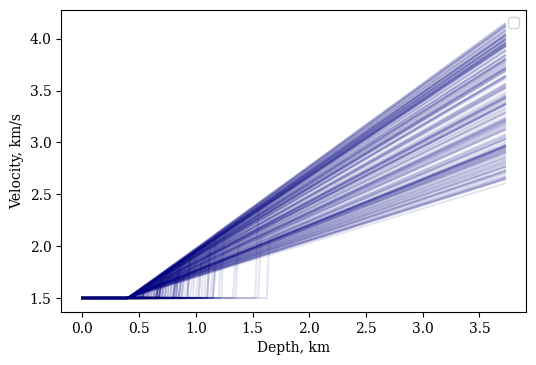

In [9]:
# Lines
# importlib.reload(vis)
log_idx=300;dx=25
# true_log = model_init.vp[::-1, log_idx] / 1000
print(other_models[0].shape)
for imodel in range(nmodels-1):
    log = other_models_init[imodel][log_idx,:] / 1000
    xax = dx * np.arange(len(log)) / 1000
    plt.plot(xax, log, 'navy', alpha=0.1)
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s'); plt.legend();
# vis.savefig('vlogs.png')

In [10]:
# Images
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', 
#                colorbar=False,
               **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', 
#                colorbar=False,
               axis='off')

for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
    vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box
#                    title=f'Model {i+1} / {nmodels}'
                  )

NameError: name 'par_box_km' is not defined

In [90]:
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

(1024, 152, 500)


(1024, 152)
(1024,)


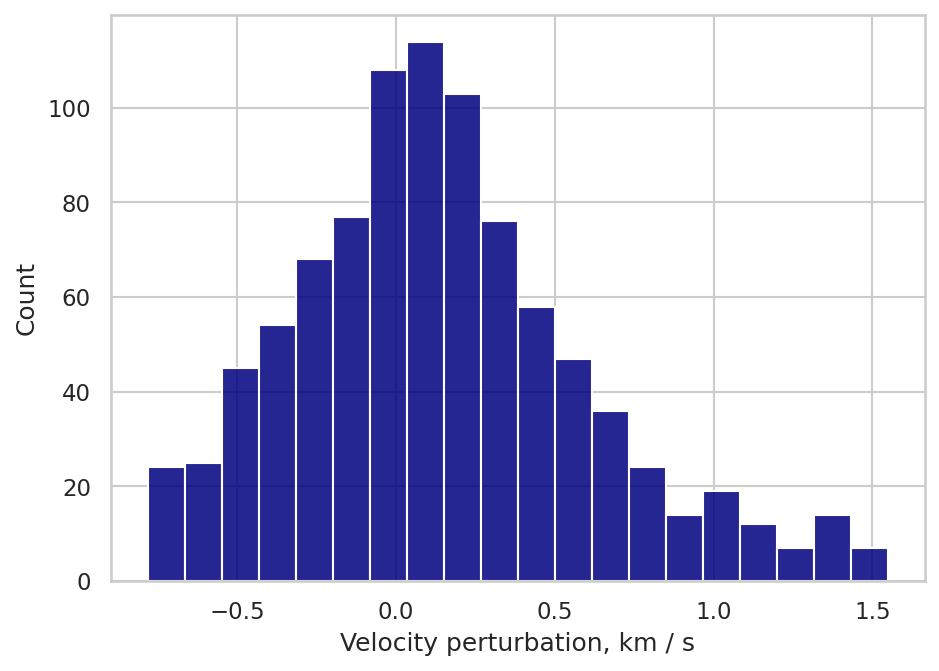

In [91]:
# dist = np.mean((vol - np.mean(vol, keepdims=True))[:, :, log_idx], 1)
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
print(the_log.shape)
dist = the_log[:, the_log.shape[-1] // 2]
print(dist.shape)

sns.set(style='whitegrid', 
#         palette="deep", 
        palette="Blues_r", 
        rc={"figure.figsize": [7, 5]})


sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count');

In [247]:
rec_syn = copy.deepcopy(rec)
xsrc0 = src.x[0]
dsrc_syn = 1000.
_nsrc = 3
xsrc = xsrc0 + np.arange(_nsrc) * dsrc_syn
ysrc = np.array([src.y[0] for _ in range(_nsrc)])

src_syn_ac = api.Sources(xsrc, ysrc)
wls = bpw[:len(src_syn_ac), ::2]
src_syn_ac.wavelets = -wls[:, :limit_nt]
print(src_syn_ac)
print(rec_syn)

name:	
x	(3,):	min: 1500.0	max: 3500.0
y	(3,):	min: 50.0	max: 50.0
wavelets	(3, 3000):	min: -6.286853676317875	max: 5.2003522040678645
z	(3,):	min: 0.0	max: 0.0
nshot:	3
td	(3,):	min: 0.0	max: 0.0
fc	(3,):	min: 8.0	max: 8.0
amp	(3,):	min: 1.0	max: 1.0
angle	(3,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(3,):	min: 1.0	max: 1.0
x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [248]:
# d.NT = 3000

In [249]:
# Init Denise for syn data generation
d_syn = copy.deepcopy(d)
d_syn.verbose = 1
d_syn.NPROCX = 4
d_syn.NPROCY = 1

d_syn.DT = dDT
d_syn.NT = d.NT + ext_nt
d_syn.TIME = dDT * d_syn.NT
d_syn.N_STREAMER = len(rec_syn[0])
d_syn.REC_INCR_X = dsrc_syn

d_syn.PHYSICS = 2

print(d_syn.NT, d_syn.DT)

3100 0.002


/data/oleg/raw/syn_1024_ac_vel/
152 500


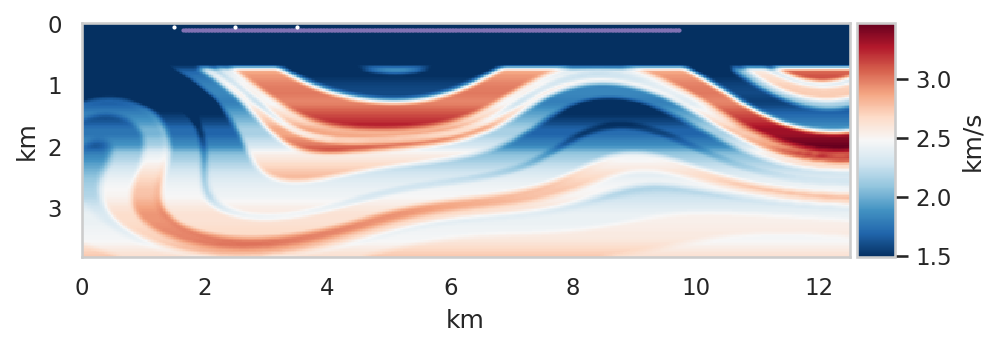

In [299]:
print(root_home)
def make_vp_vs_rho(vp):
    vs = vp.copy() / (3 ** 0.5)
    taper = vp < 1.01 * np.min(vp)
    vs = np.where(taper, 0, vs)
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(taper, 1000, rho)
    return vp, vs, rho

model_syn = api.Model(*make_vp_vs_rho(other_models[0]), dx)
print(model_syn.nz, model_syn.nx)
mpl.rcParams['axes.grid']= False
vis.plot_acquisition(model_syn.vp, dx, src_syn_ac, rec_syn)
# vis.savefig('rand_acq.png')

# Start modeling acoustic data

In [251]:
def _run_model(im, m, dx, path_output, src_this, run_command):
    _d_syn = copy.deepcopy(d_syn)
    _d_syn.verbose = 0
    d_syn.QUELLART = 3 # custom wavelet
    _d_syn.save_folder = os.path.join(path_output, f'model_{im}/')
    os.makedirs(_d_syn.save_folder, exist_ok=True)
    vp, vs, rho = make_vp_vs_rho(m)
    model_syn = api.Model(vp, vs, rho, dx)
    clear_output()
    _d_syn.forward(model_syn, src_this, rec_syn, run_command)
    return None

if not os.path.exists(path_save_rand_models):
    num_simultaneous_runs = 12
    print('Start parallel pool for modeling...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
        tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
                                           itertools.repeat(dx), 
                                           itertools.repeat(root_home),
                                           itertools.repeat(src_syn_ac),
                                           itertools.repeat('mpirun -np 4')))
        print(f'OK, {time.time() - t1} sec')

### Save random models

In [252]:
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [253]:
_path_syn_dataset = os.path.join(root_dataset_syn, 'train/raw/')
os.makedirs(_path_syn_dataset, exist_ok=True)
print(_path_syn_dataset)

/data/oleg/data/syn_1024_ac_vel/train/raw/


In [254]:
_path_field_dataset = os.path.join(root_dataset_field, 'train/raw/')
os.makedirs(_path_field_dataset, exist_ok=True)
print(_path_field_dataset)

/data/oleg/data/cgg_1024_ac_vel/train/raw/


In [255]:
# importlib.reload(datasetmaker)

override = False

par_split = {}
par_split['format'] = '.hh'
par_split['dir_dataset'] = root_dataset_syn
par_split['dir_syn'] = root_home
par_split['partitions'] = [90, 5, 5]
par_split['split_from_files'] = False
par_split['split_hh'] = False
par_split['file_keys'] = ['.su']
par_split['from_files'] = False
par_split['jump_files'] = 1
par_split['rules'] = {'raw': 'sfbandpass fhi=15 | sfwindow j1=1'}
par_split['jump_folders'] = 1
par_split['delete_old'] = False
par_split['pre'] = 'sfsuread endian=n su=y |'
par_split['post'] = ' '


if ld.is_empty(_path_syn_dataset) or override:
    maker = datasetmaker.DatasetMaker(par_split, verbose=1)
    maker.run()
    print(f'Check syn dataset in {_path_syn_dataset}')

In [256]:
path_save_field = os.path.join(root_dataset_field, 'data_cgg_ext.npy')
if not os.path.exists(path_save_field):
    os.makedirs(root_dataset_field, exist_ok=True)
    print(f'Save {data_p_ext.shape} to {path_save_field}')
    np.save(path_save_field, data_p_ext)
    
path_save_rand_models = os.path.join(root_dataset_syn, 'rand_models.npy')
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [257]:
par_loader={'crop': (None, None), 'skip': (1,1), 'norm': True}
cube_dst = np.load(path_save_field)
loader_dst_tr = ld.CubeLoader(cube_dst, par_loader)

print(_path_syn_dataset)
fnames_ac = ld.parse_files(_path_syn_dataset, '*.hh')
loader_src_tr_ac = ld.Loader(fnames_ac, par_loader)

jloader_tr = ld.JointLoader(loader_src_tr_ac, loader_dst_tr)

/data/oleg/data/syn_1024_ac_vel/train/raw/
Found 2765 files in /data/oleg/data/syn_1024_ac_vel/train/raw/:
	/data/oleg/data/syn_1024_ac_vel/train/raw/model_0_seis_p.shot2.hh
	/data/oleg/data/syn_1024_ac_vel/train/raw/model_1023_seis_p.shot3.hh


In [258]:
index = 2
print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset}\n\tfield:\t{_path_field_dataset}\n')
dat = jloader_tr.__getitem__(index)
print(len(dat), dat[0].shape, dat[2].shape)

Init loader for:
	syn:	/data/oleg/data/syn_1024_ac_vel/train/raw/
	field:	/data/oleg/data/cgg_1024_ac_vel/train/raw/

4 (324, 3100) (324, 3100)


In [259]:
def valinfo(v):
    return v.shape, v.min(), v.max()
    
dat_src = dat[0]
print(dat[1], valinfo(dat_src))
dat_dst = dat[2]
print(dat[3], valinfo(dat_dst))

/data/oleg/data/syn_1024_ac_vel/train/raw/model_1_seis_p.shot1.hh ((324, 3100), -0.7488092, 1.0)
2 ((324, 3100), -1.0, 0.81601167)


Syn:	(324, 3100)
Field:	(324, 3100)


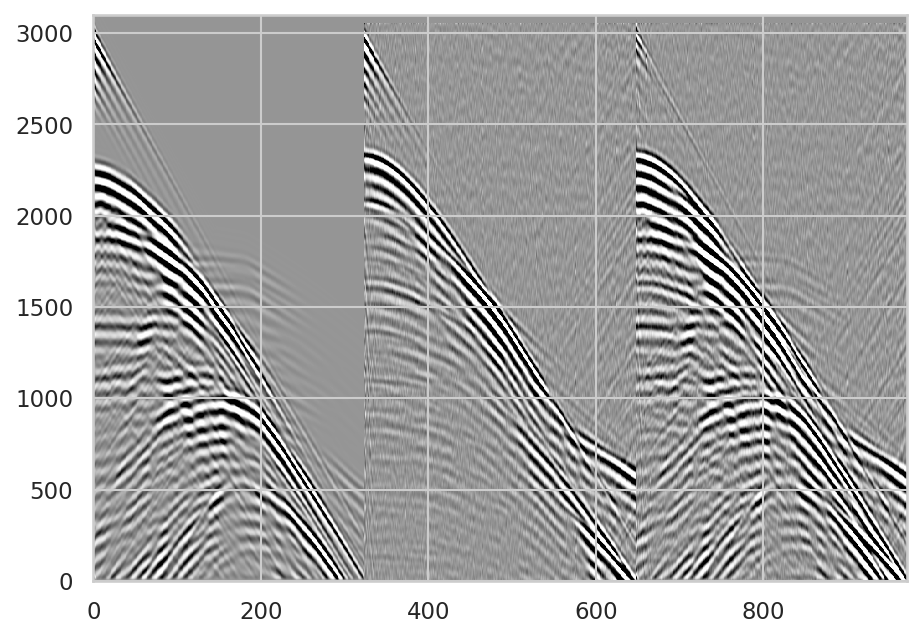

In [260]:
# importlib.reload(ld)
vis.compare_shots(dat_src, dat_dst, 0.1)
print(f'Syn:\t{dat_src.shape}\nField:\t{dat_dst.shape}')

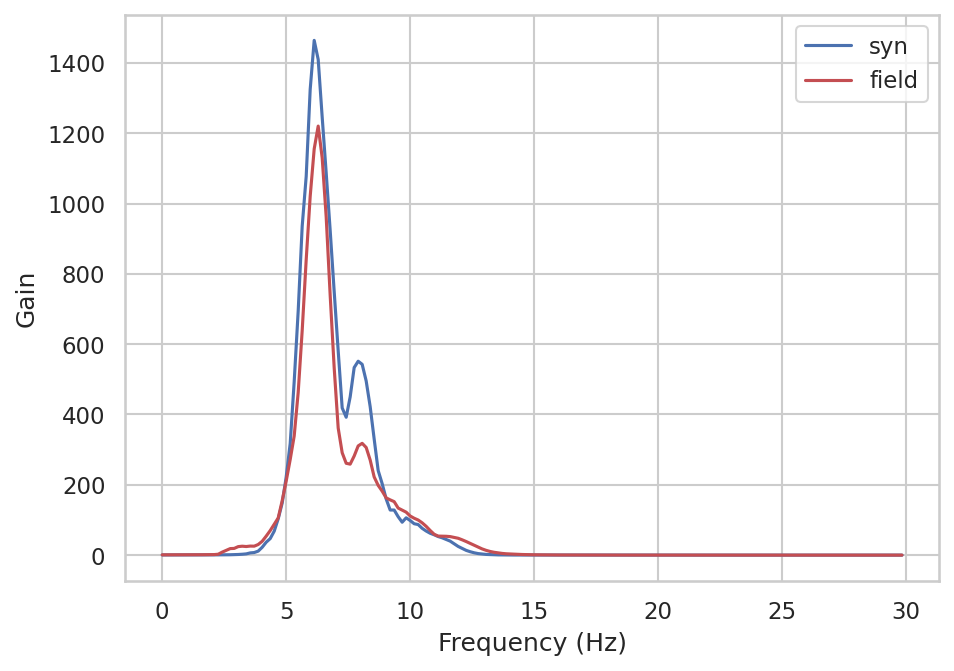

In [261]:
vis.plot_spectra_dict([{'syn': dat_src}, {'field': dat_dst}], d.DT, 30, labels=['', '', ''], norm=False)

In [262]:
# Mean train dataset
def get_loader_stats(loader, dat_shape):
    n_src_tr = len(loader)
    dat_src_tr = np.zeros((n_src_tr, *dat_shape))
    for i in range(n_src_tr):
        print(f'{i+1}/{n_src_tr}', end='\r')
        dat = loader.__getitem__(i)[0]
        if np.isnan(dat).any():
            dat = 0.
            print('NaN caught!')
        dat_src_tr[i,...] = dat
        
    src_tr_mean = np.mean(dat_src_tr, 0)
    src_tr_std = np.std(dat_src_tr, 0)
    return src_tr_mean, src_tr_std

path_src_tr_mean = os.path.join(root_dataset_syn, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn, 'src_tr_std.npy')
path_dst_tr_mean = os.path.join(root_dataset_syn, 'dst_tr_mean.npy')
path_dst_tr_std = os.path.join(root_dataset_syn, 'dst_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_ac, dat_src.shape)
    dst_tr_mean, dst_tr_std = get_loader_stats(loader_dst_tr, dat_dst.shape)
    np.save(path_src_tr_mean, src_tr_mean)
    np.save(path_src_tr_std, src_tr_std)
    np.save(path_dst_tr_mean, dst_tr_mean)
    np.save(path_dst_tr_std, dst_tr_std)
else:
    print(f'Load mean and std from {path_src_tr_mean}')
    src_tr_mean = np.load(path_src_tr_mean)
    src_tr_std = np.load(path_src_tr_std)
    dst_tr_mean = np.load(path_dst_tr_mean)
    dst_tr_std = np.load(path_dst_tr_std)

Load mean and std from /data/oleg/data/syn_1024_ac_vel/src_tr_mean.npy


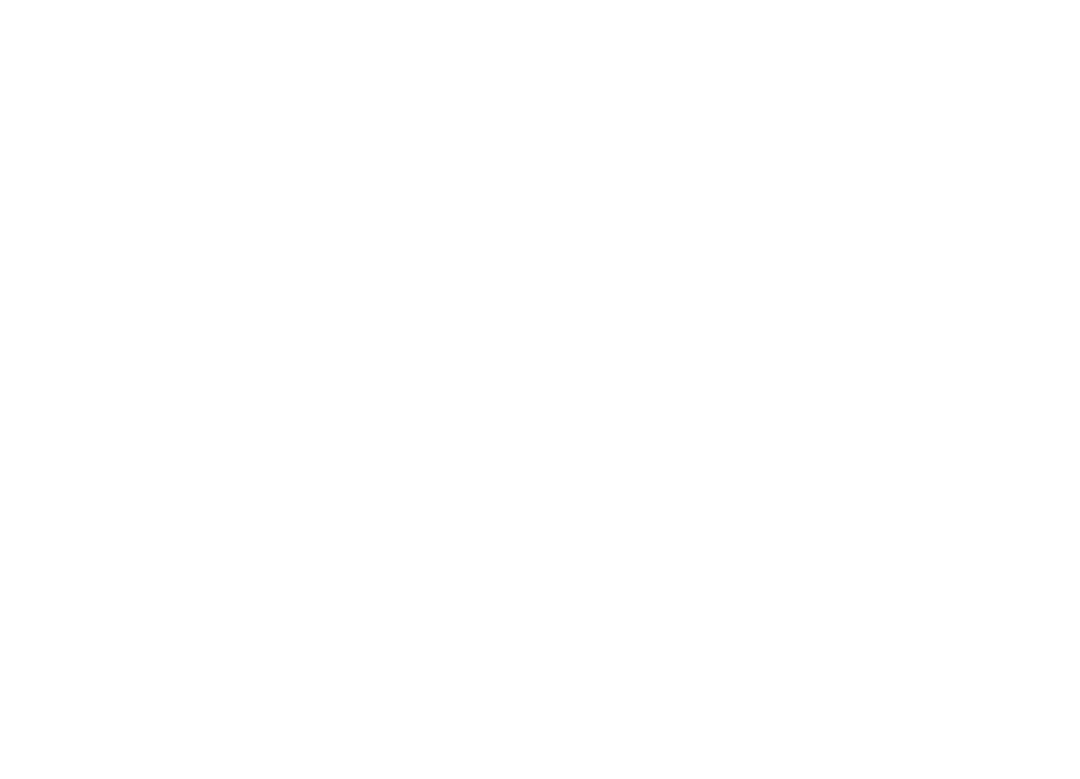

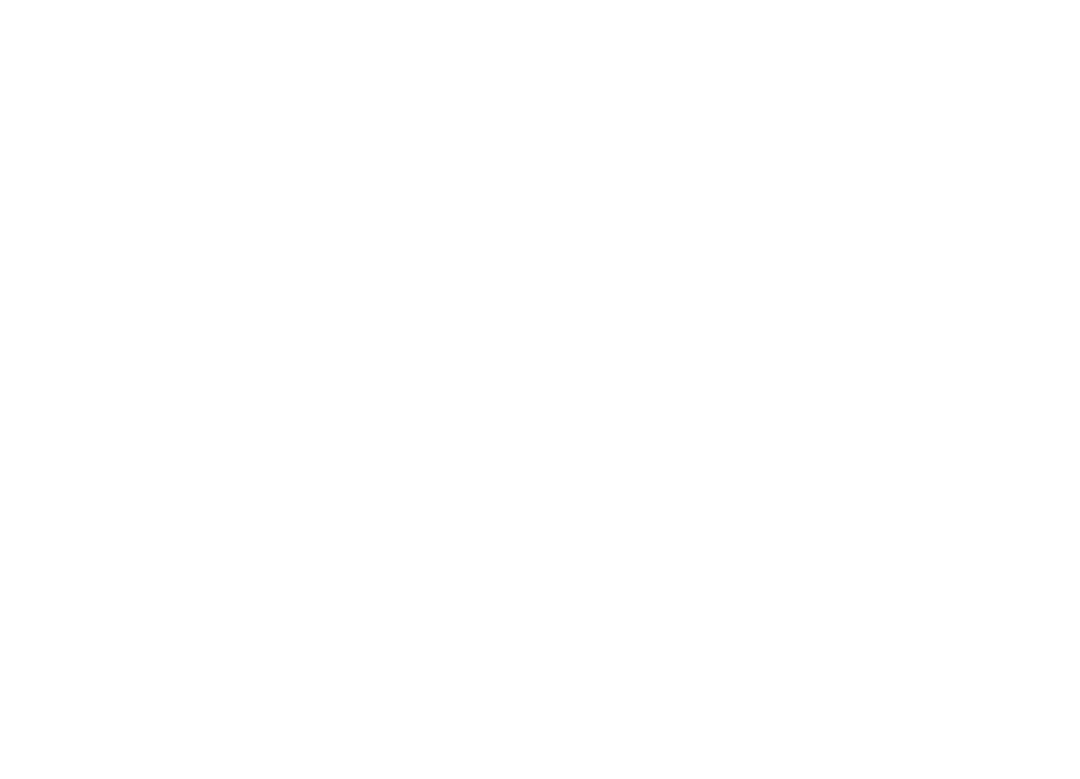

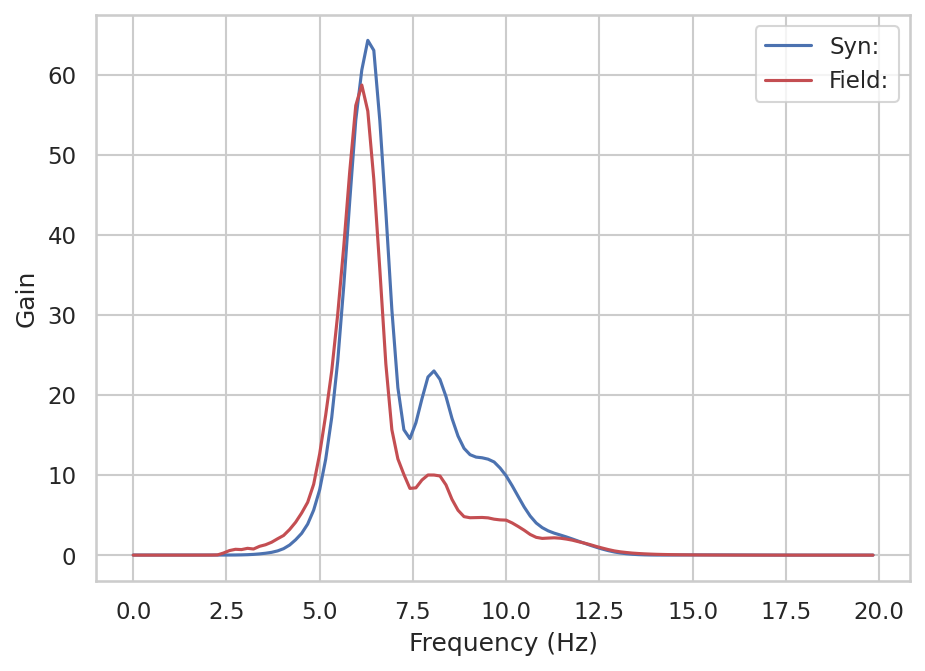

In [263]:
vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Same models but elastic modeling

In [264]:
root_home_el = '/data/oleg/raw/syn_1024_el_vel/'  
root_dataset_field_el = os.path.join(root_out, 'cgg_1024_el_vel')
root_dataset_syn_el = os.path.join(root_out, 'syn_1024_el_vel')

# root_home_el = '/data/oleg/raw/test_syn_32_el_vel/'  
# root_dataset_field_el = os.path.join(root_out, 'test_cgg_32_el_vel')
# root_dataset_syn_el = os.path.join(root_out, 'test_syn_32_el_vel')

Wavelet for elastic modeling is the same as for acoustic but flipped (there mush be a bug in the source C code)

In [265]:
d_syn.SEISMO = 2
d_syn.PHYSICS = 1
d_syn.NPROCX = 2
src_syn_el = copy.deepcopy(src_syn_ac)
src_syn_el.wavelets = wls[:, :limit_nt]

# Start modeling elastic data

In [266]:
if ld.is_empty(root_home_el):
    num_simultaneous_runs = 8
    # NCORES = NRUNS * (NSRC * NPROCX * NPROCY) = 8 * (3 * 2) = 48. Brackets outlune nproc for every run
    print('Start parallel pool for modeling...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
        tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
                                           itertools.repeat(dx), 
                                           itertools.repeat(root_home_el),
                                           itertools.repeat(src_syn_el),
                                           itertools.repeat('mpirun -np 6')))
    print(f'OK, {time.time() - t1} sec')

In [267]:
_path_syn_dataset_el = os.path.join(root_dataset_syn_el, 'train/raw/')
os.makedirs(_path_syn_dataset_el, exist_ok=True)
print(_path_syn_dataset_el)

/data/oleg/data/syn_1024_el_vel/train/raw/


In [268]:
par_split_el = copy.deepcopy(par_split)
par_split_el['dir_dataset'] = root_dataset_syn_el
par_split_el['dir_syn'] = root_home_el

if ld.is_empty(_path_syn_dataset_el) or override:
    maker = datasetmaker.DatasetMaker(par_split_el, verbose=1)
    maker.run()
print(f'Check syn dataset in {_path_syn_dataset_el}')

Check syn dataset in /data/oleg/data/syn_1024_el_vel/train/raw/


In [269]:
path_save_field_el = os.path.join(root_dataset_field_el, 'data_cgg_ext.npy')
if not os.path.exists(path_save_field_el):
    os.makedirs(root_dataset_field_el, exist_ok=True)
    print(f'Save {data_p_ext.shape} to {path_save_field_el}')
    np.save(path_save_field_el, data_p_ext)

path_save_rand_models = os.path.join(root_dataset_syn_el, 'rand_models.npy')
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [270]:
print(_path_syn_dataset_el)
fnames_el = ld.parse_files(_path_syn_dataset_el, '*.hh', verbose=0)
loader_src_tr_el = ld.Loader(fnames_el, par_loader)

jloader_tr = ld.JointLoader(loader_src_tr_el, loader_dst_tr)

print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset_el}\n\tfield:\t{_path_field_dataset}\n')
dat = jloader_tr.__getitem__(index)
print(len(dat), dat[0].shape, dat[2].shape)

/data/oleg/data/syn_1024_el_vel/train/raw/
Init loader for:
	syn:	/data/oleg/data/syn_1024_el_vel/train/raw/
	field:	/data/oleg/data/cgg_1024_ac_vel/train/raw/

4 (324, 3100) (324, 3100)


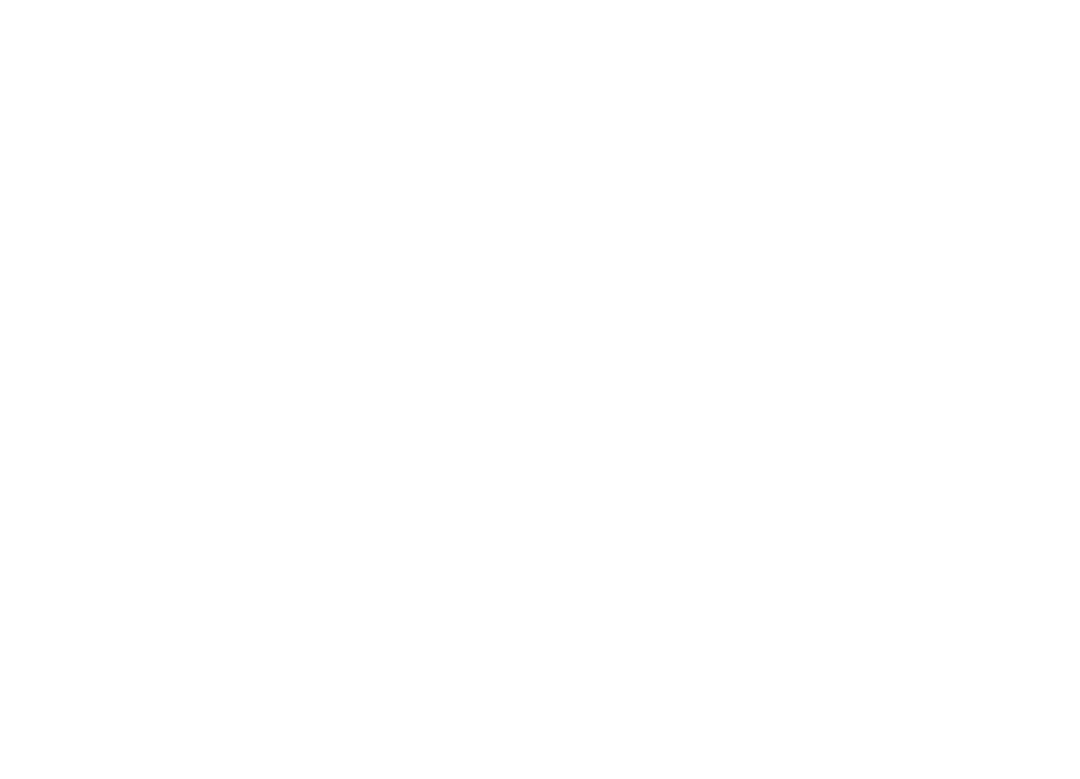

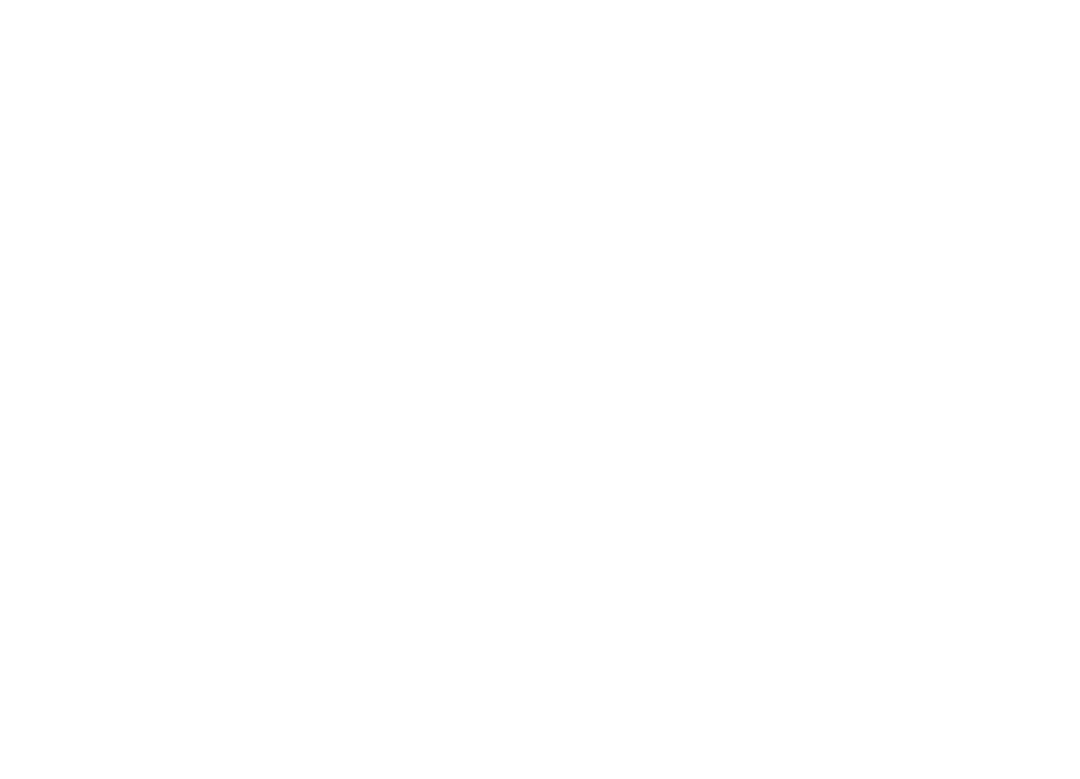

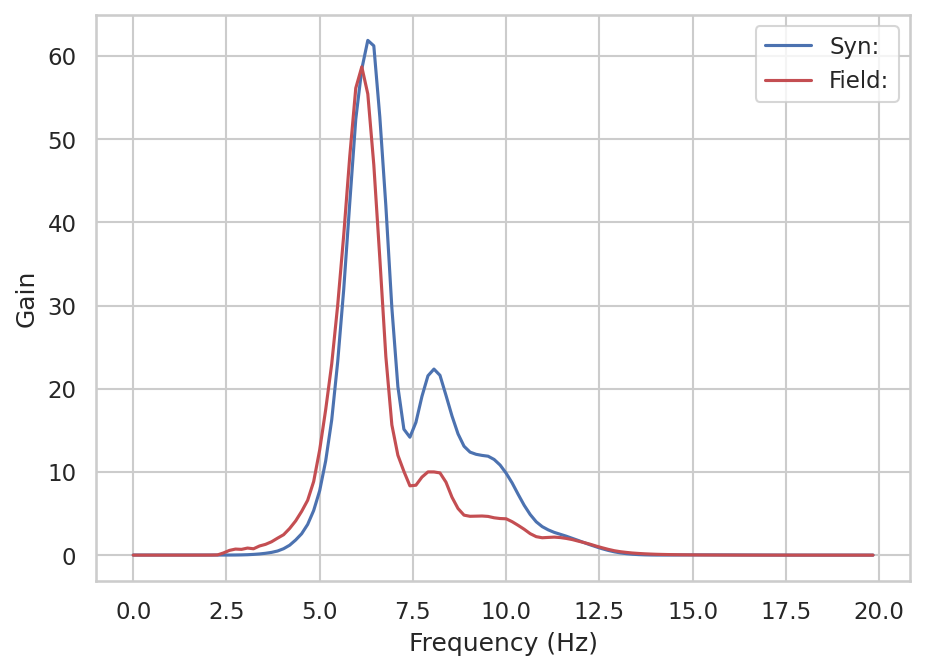

In [271]:
path_src_tr_mean = os.path.join(root_dataset_syn_el, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_el, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_el, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean)
    np.save(path_src_tr_std, src_tr_std)
else:
    src_tr_mean = np.load(path_src_tr_mean)
    src_tr_std = np.load(path_src_tr_std)

vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Spike elastic data

In [272]:
# root_home_spike = '/home/ovcharoo/spike_1024_el/'  
# root_dataset_syn_spike = os.path.join(root_out, 'spike_1024_el')

In [273]:
# def _run_model_spike(im, m, dx, path_output, src_this, run_command):
#     _d_syn = copy.deepcopy(d_syn)
#     _d_syn.verbose = 0
#     _d_syn.QUELLART = 6 # spike
#     _d_syn.FC_SPIKE_2 = 6
#     _d_syn.save_folder = os.path.join(path_output, f'model_{im}/')
#     os.makedirs(_d_syn.save_folder, exist_ok=True)
#     vp, vs, rho = make_vp_vs_rho(m)
#     model_syn = api.Model(vp, vs, rho, dx)
#     clear_output()
#     _d_syn.forward(model_syn, src_this, rec_syn, run_command)
#     return None

# if ld.is_empty(root_home_spike):
#     num_simultaneous_runs = 8
#     # NCORES = NRUNS * (NSRC * NPROCX * NPROCY) = 8 * (3 * 2) = 48. Brackets outlune nproc for every run
#     print('Start parallel pool for modeling...', end='')
#     model_ids = [i for i in range(nmodels)]
#     t1 = time.time()
#     with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
#         tmp = pool.starmap(_run_model_spike, zip(model_ids, other_models, 
#                                            itertools.repeat(dx), 
#                                            itertools.repeat(root_home_spike),
#                                            # Use the same source as elastic, but change flag QUELLART on the fly
#                                            itertools.repeat(src_syn_el),
#                                            itertools.repeat('mpirun -np 6')))

In [274]:
# _path_syn_dataset_spike = os.path.join(root_dataset_syn_spike, 'train/raw/')
# os.makedirs(_path_syn_dataset_el, exist_ok=True)
# print(_path_syn_dataset_spike)

In [275]:
# par_split_spike = copy.deepcopy(par_split)
# par_split_spike['dir_dataset'] = root_dataset_syn_spike
# par_split_spike['dir_syn'] = root_home_spike

# if ld.is_empty(_path_syn_dataset_spike) or override:
#     maker = datasetmaker.DatasetMaker(par_split_spike, verbose=1)
#     maker.run()
# print(f'Check syn dataset in {_path_syn_dataset_spike}')

In [276]:
# print(_path_syn_dataset_spike)
# fnames_spike = ld.parse_files(_path_syn_dataset_spike, '*.hh', verbose=0)
# loader_src_tr_spike = ld.Loader(fnames_spike, par_loader)

# jloader_tr = ld.JointLoader(loader_src_tr_spike, loader_dst_tr)

# print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset_el}\n\tfield:\t{_path_field_dataset}\n')
# dat = jloader_tr.__getitem__(index)
# print(len(dat), dat[0].shape, dat[2].shape)

# path_src_tr_mean = os.path.join(root_dataset_syn_spike, 'src_tr_mean.npy')
# path_src_tr_std = os.path.join(root_dataset_syn_spike, 'src_tr_std.npy')
# if not os.path.exists(path_src_tr_mean):
#     src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_spike, dat_src.shape)
#     np.save(path_src_tr_mean, src_tr_mean)
#     np.save(path_src_tr_std, src_tr_std)
# else:
#     src_tr_mean = np.load(path_src_tr_mean)
#     src_tr_std = np.load(path_src_tr_std)

# vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
#               title='Mean synthetic / field', colorbar=True,
#               dt=d.DT, vmin=-0.1, vmax=0.1)
# vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
#               title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
# vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Match successful shots from acoustic and elastic
Acoustic modeling is prone to numerical instabilities, for some reason. For fair comparison we have to filter out unsuccessful shots first.

In [277]:
selected_fnames_ac = []
for i in range(len(loader_src_tr_ac)):
    dat_ac, fname_ac = loader_src_tr_ac.__getitem__(i)
    if np.mean(np.abs(dat_ac)) > 1e-3:
        selected_fnames_ac.append(fname_ac)
print(f'Filter out failed acoustic shots: {len(loader_src_tr_ac)} --> {len(selected_fnames_ac)}')

Filter out failed acoustic shots: 2765 --> 2765


In [278]:
print(f'Num acoustic files:\t{len(selected_fnames_ac)}\nNum elastic files:\t{len(fnames_el)}')
subset_ac = set([os.path.split(f)[-1] for f in selected_fnames_ac])
subset_el = set([os.path.split(f)[-1] for f in fnames_el])
print(f'Num unique acoustic files:\t{len(subset_ac)}\nNum unique elastic files:\t{len(subset_el)}')

Num acoustic files:	2765
Num elastic files:	2765
Num unique acoustic files:	2765
Num unique elastic files:	2765


In [279]:
# print('\n'.join(natsorted(subset_ac)))
# print('----------------------------------------')
# print('\n'.join(natsorted(subset_el)))
# print('----------------------------------------')
# common_files = [f for f in subset_ac if f in subset_el]
# rejected_files = [f for f in subset_ac if f not in subset_el]
common_files = list(subset_ac & subset_el)
print(f'Number of commonly successful files: {len(common_files)}')
# print('\n'.join(rejected_files))

sorted_fnames_ac = [os.path.join(os.path.split(selected_fnames_ac[0])[0], f) for f in common_files]
sorted_fnames_el = [os.path.join(os.path.split(fnames_el[0])[0], f) for f in common_files]

Number of commonly successful files: 2765


In [280]:
loader_src_tr_ac = ld.Loader(sorted_fnames_ac, par_loader)
loader_src_tr_el = ld.Loader(sorted_fnames_el, par_loader)

jjloader_tr = ld.JointLoader(loader_src_tr_ac, loader_src_tr_el)

Temporal sampling: 0.002
Model id: 324, shot id: 2
/data/oleg/data/syn_1024_ac_vel/train/raw/model_324_seis_p.shot2.hh ((324, 3100), -0.7314831, 1.0) 0.039782997
/data/oleg/data/syn_1024_el_vel/train/raw/model_324_seis_p.shot2.hh ((324, 3100), -0.7314831, 1.0) 0.02917861


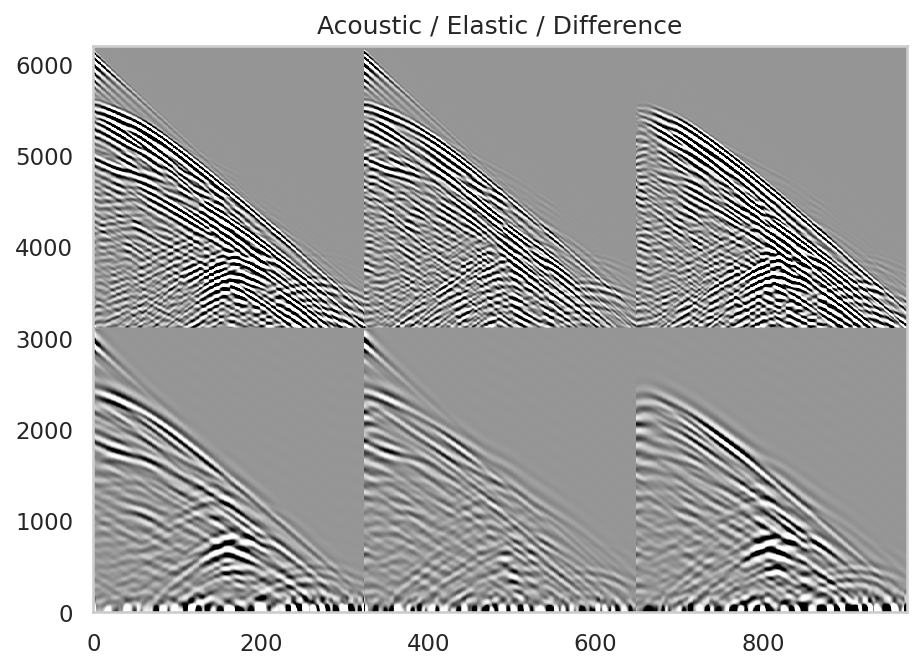

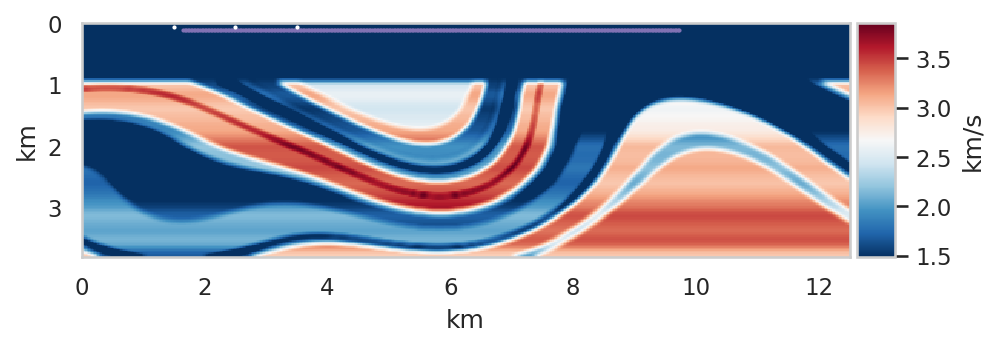

In [316]:
index += 1
dat_el = jjloader_tr.__getitem__(index)

par_bp = {'fs': 1/(d_syn.DT * d_syn.NDT), 'fhi': 3, 'btype': 'low'}
print(f'Temporal sampling: {d_syn.DT * d_syn.NDT}')

dat_src_ac = dat_el[0]
dat_src_el = dat_el[2]

model_id = int((os.path.split(dat_el[1])[-1]).split('_')[1])
shot_id = int((os.path.split(dat_el[1])[-1]).split('.')[-2].replace('shot', ''))
print(f'Model id: {model_id}, shot id: {shot_id}')

print(dat_el[1], valinfo(dat_src_ac), np.mean(np.abs(dat_src_ac)))
print(dat_el[3], valinfo(dat_src_el), np.mean(np.abs(dat_src_el)))

vis.plot_shot(np.concatenate([ld.divmax(np.concatenate([dat_src_ac, dat_src_el, dat_src_el - dat_src_ac], 0)),
                             ld.divmax(np.concatenate([ld.bandpass(dat_src_ac, **par_bp),
                                                       ld.bandpass(dat_src_el, **par_bp),
                                                       ld.bandpass(dat_src_el - dat_src_ac, **par_bp)], 0))], 1),
             pclip=0.1,
             axis='off',
             title='Acoustic / Elastic / Difference')
vis.plot_acquisition(other_models[model_id], dx, src_syn_ac, rec_syn)
# print(f'Syn:\t{dat_src.shape}\nField:\t{dat_src_el.shape}')

# Save compatible datasets as new

In [282]:
root_dataset_syn_ac = copy.copy(root_dataset_syn)
root_dataset_syn_filt_ac = root_dataset_syn_ac.replace('_ac', '_filt_ac')
print(f'Acoustic:\n\t{root_dataset_syn} -->\n\t{root_dataset_syn_filt_ac}')

root_dataset_syn_filt_el = root_dataset_syn_el.replace('_el', '_filt_el')
print(f'Elastic:\n\t{root_dataset_syn_el} -->\n\t{root_dataset_syn_filt_el}')

Acoustic:
	/data/oleg/data/syn_1024_ac_vel -->
	/data/oleg/data/syn_1024_filt_ac_vel
Elastic:
	/data/oleg/data/syn_1024_el_vel -->
	/data/oleg/data/syn_1024_filt_el_vel


# Acoustic

In [283]:
if not os.path.exists(root_dataset_syn_filt_ac):
    cmd = f'cp -r {root_dataset_syn_ac} {root_dataset_syn_filt_ac}'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/cube*.npy'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    commands = []
    for f in sorted_fnames_ac:
        cmd = f'cp {f} {f.replace(root_dataset_syn_ac, root_dataset_syn_filt_ac)}'
        commands.append(cmd)
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

## Elastic

In [284]:
if not os.path.exists(root_dataset_syn_filt_el):
    cmd = f'cp -r {root_dataset_syn_el} {root_dataset_syn_filt_el}'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/cube*.npy'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    commands = []
    for f in sorted_fnames_el:
        cmd = f'cp {f} {f.replace(root_dataset_syn_el, root_dataset_syn_filt_el)}'
        commands.append(cmd)
        
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

# Init loaders and compare mean and std

In [285]:
path_dst_tr_mean = os.path.join(root_dataset_syn, 'dst_tr_mean.npy')
path_dst_tr_std = os.path.join(root_dataset_syn, 'dst_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    dst_tr_mean, dst_tr_std = get_loader_stats(loader_dst_tr, dat_dst.shape)
    np.save(path_dst_tr_mean, dst_tr_mean)
    np.save(path_dst_tr_std, dst_tr_std)
else:
    print(f'Load mean and std from {path_src_tr_mean}')
    dst_tr_mean = np.load(path_dst_tr_mean)
    dst_tr_std = np.load(path_dst_tr_std)

Load mean and std from /data/oleg/data/syn_1024_el_vel/src_tr_mean.npy


## Acoustic

In [286]:
sorted_fnames_ac_moved = [f.replace(root_dataset_syn_ac, root_dataset_syn_filt_ac) for f in sorted_fnames_ac]
loader_src_tr_filt_ac = ld.Loader(sorted_fnames_ac_moved, par_loader)

path_src_tr_mean = os.path.join(root_dataset_syn_ac, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_ac, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_ac, src_tr_std_ac = get_loader_stats(loader_src_tr_filt_ac, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_ac)
    np.save(path_src_tr_std, src_tr_std_ac)
else:
    src_tr_mean_ac = np.load(path_src_tr_mean)
    src_tr_std_ac = np.load(path_src_tr_std)

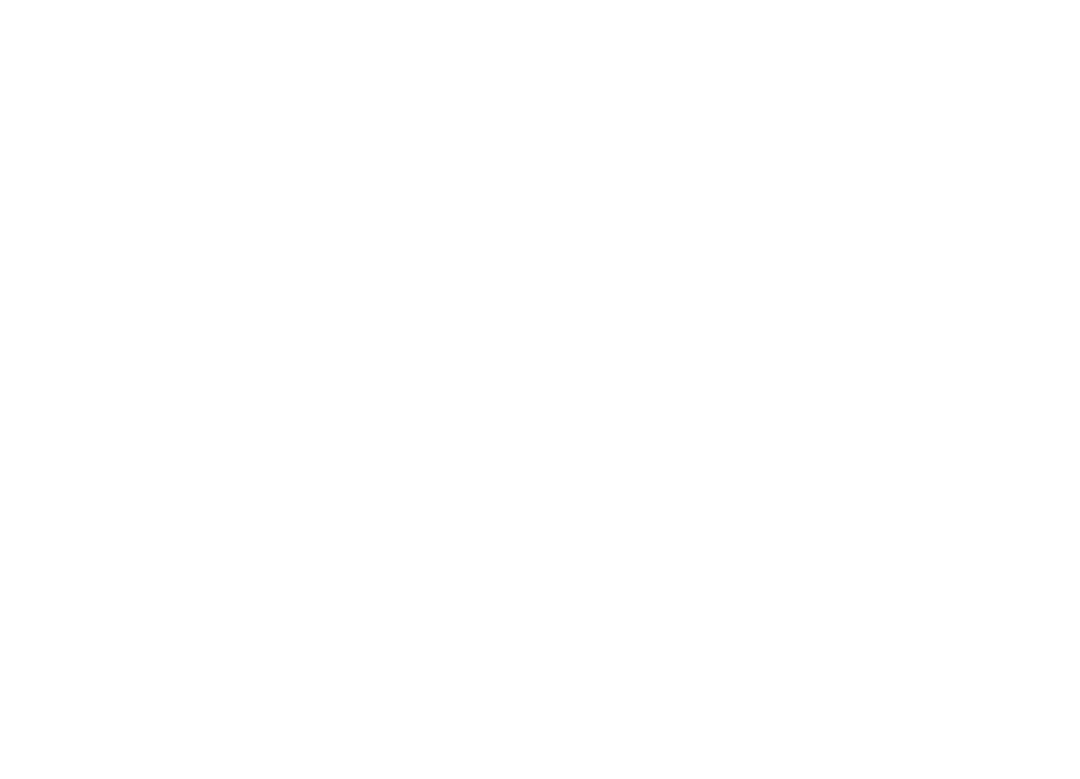

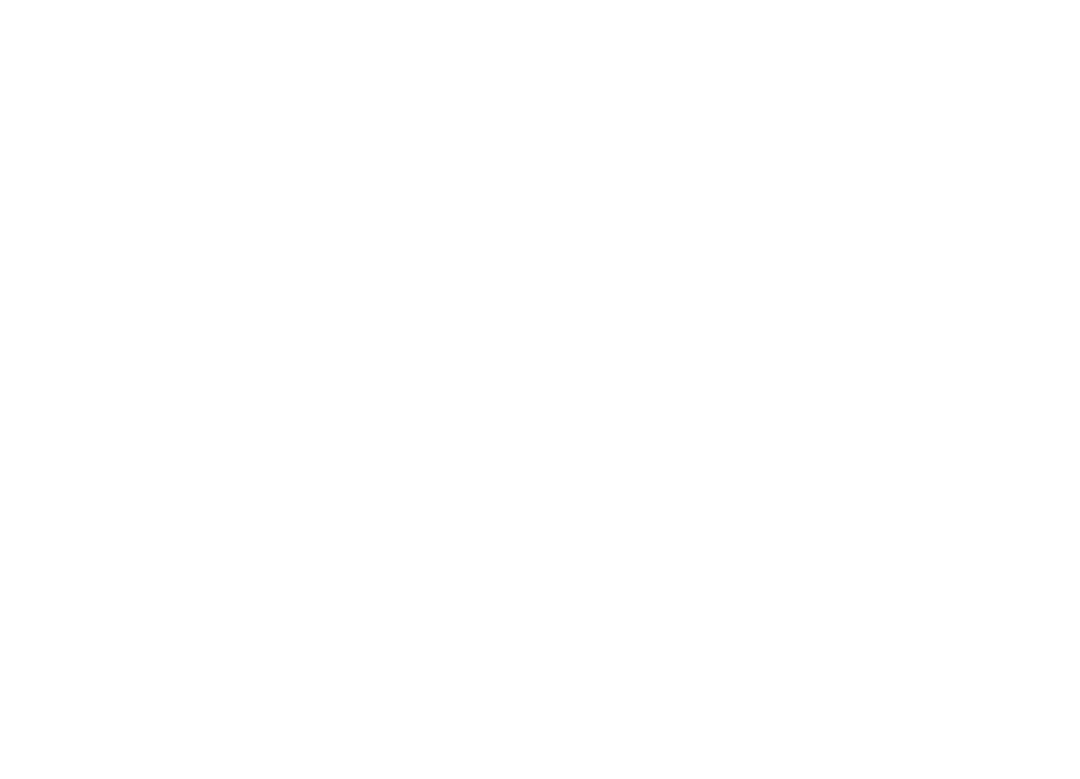

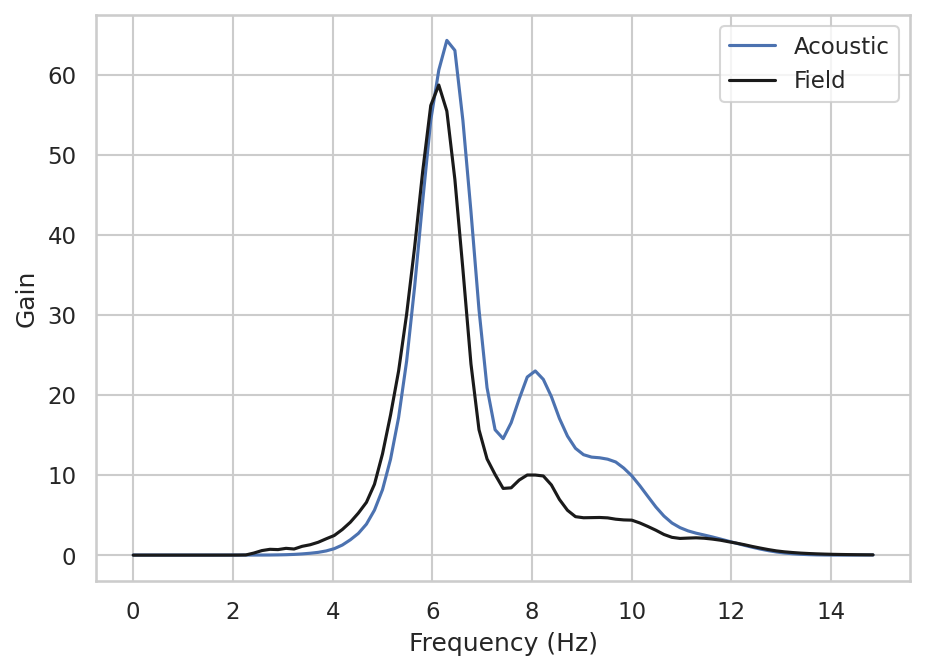

In [287]:
vis.plot_shot(np.concatenate([src_tr_mean_ac, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std_ac, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
dictlist = [{'data': src_tr_mean_ac, 'line': 'b', 'label': 'Acoustic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)

## Elastic

In [288]:
sorted_fnames_el_moved = [f.replace(root_dataset_syn_el, root_dataset_syn_filt_el) for f in sorted_fnames_el]
loader_src_tr_filt_el = ld.Loader(sorted_fnames_el_moved, par_loader)

path_src_tr_mean = os.path.join(root_dataset_syn_el, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_el, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_el, src_tr_std_el = get_loader_stats(loader_src_tr_filt_el, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_el)
    np.save(path_src_tr_std, src_tr_std_el)
else:
    src_tr_mean_el = np.load(path_src_tr_mean)
    src_tr_std_el = np.load(path_src_tr_std)

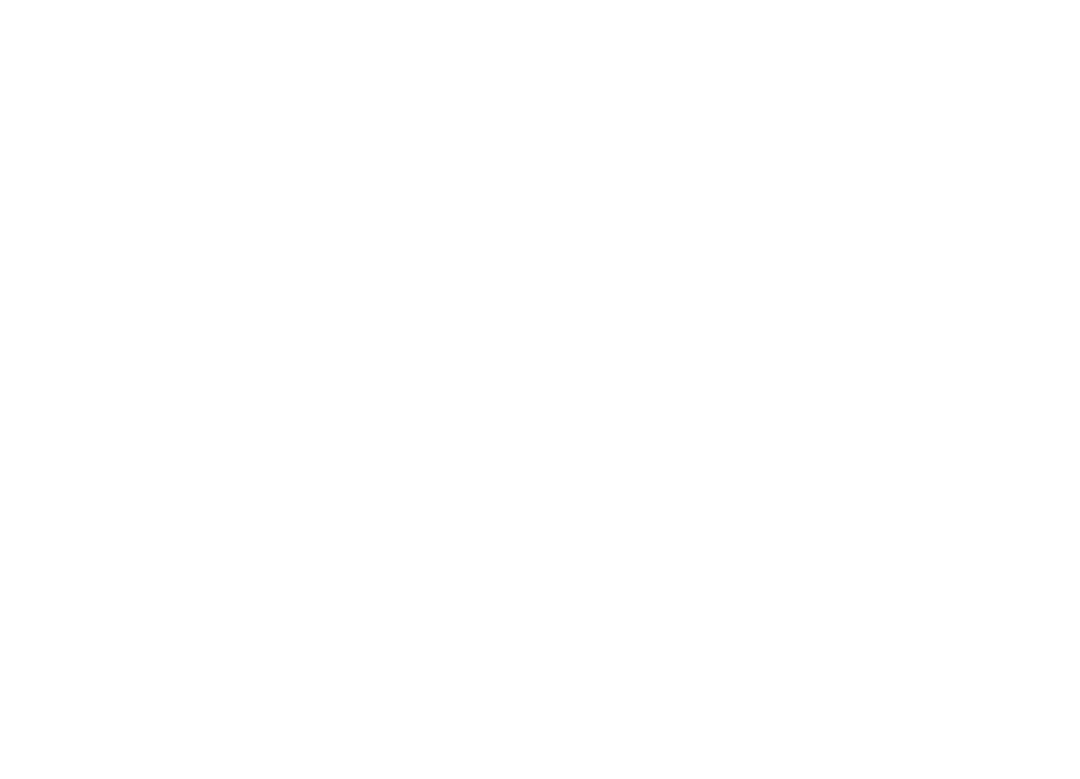

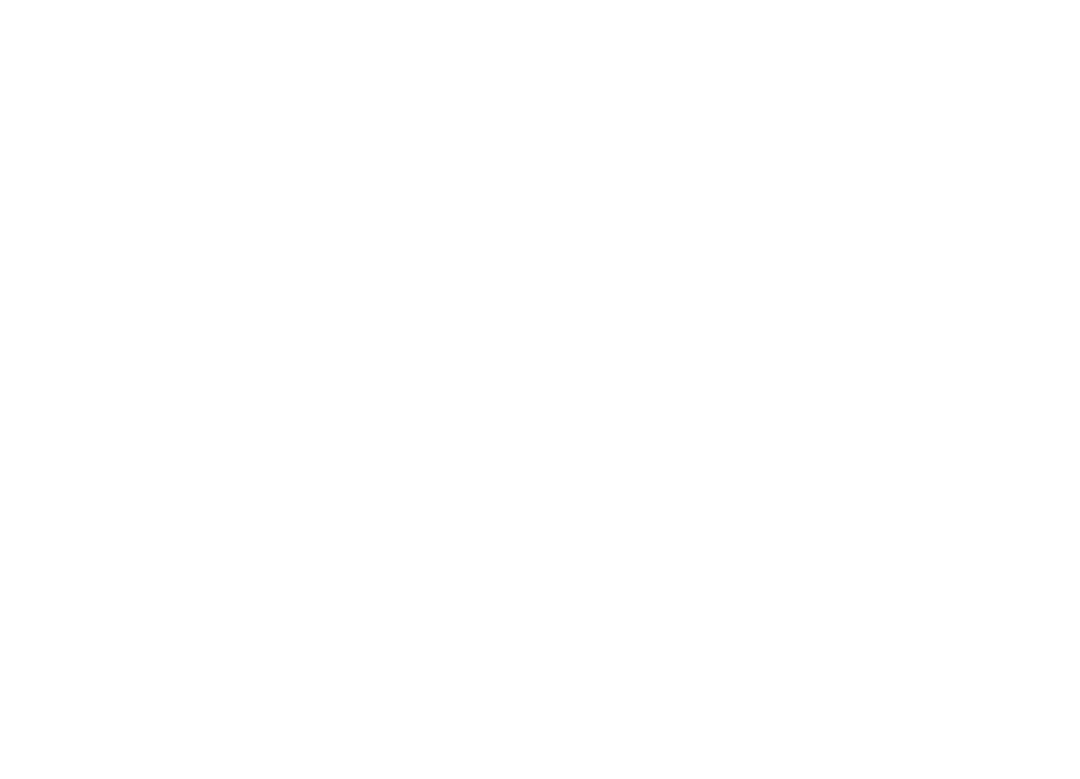

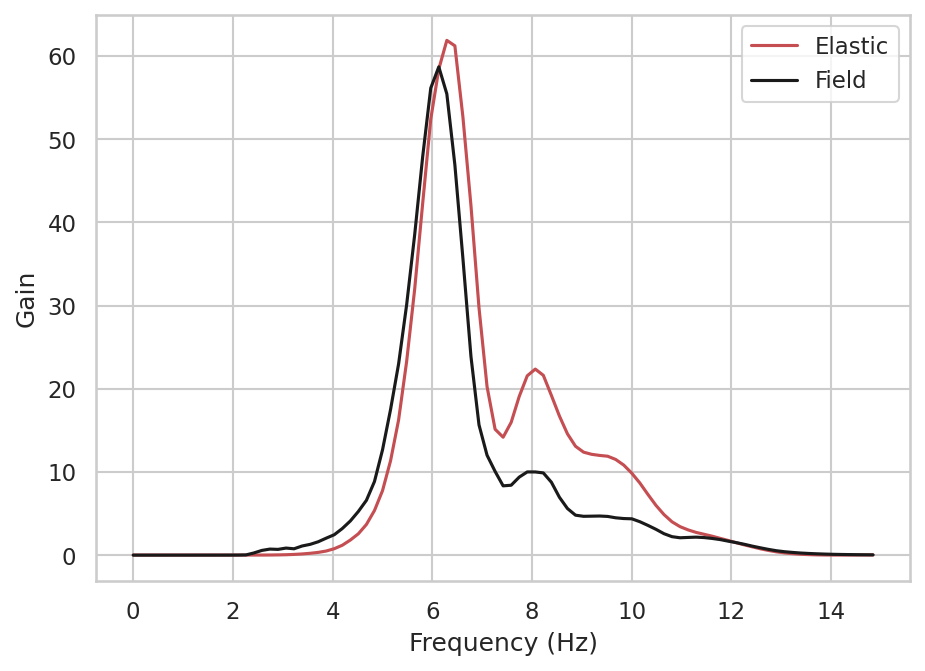

In [289]:
vis.plot_shot(np.concatenate([src_tr_mean_el, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std_el, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
dictlist = [{'data': src_tr_mean_el, 'line': 'r', 'label': 'Elastic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)

## Compare acoustic and elastic

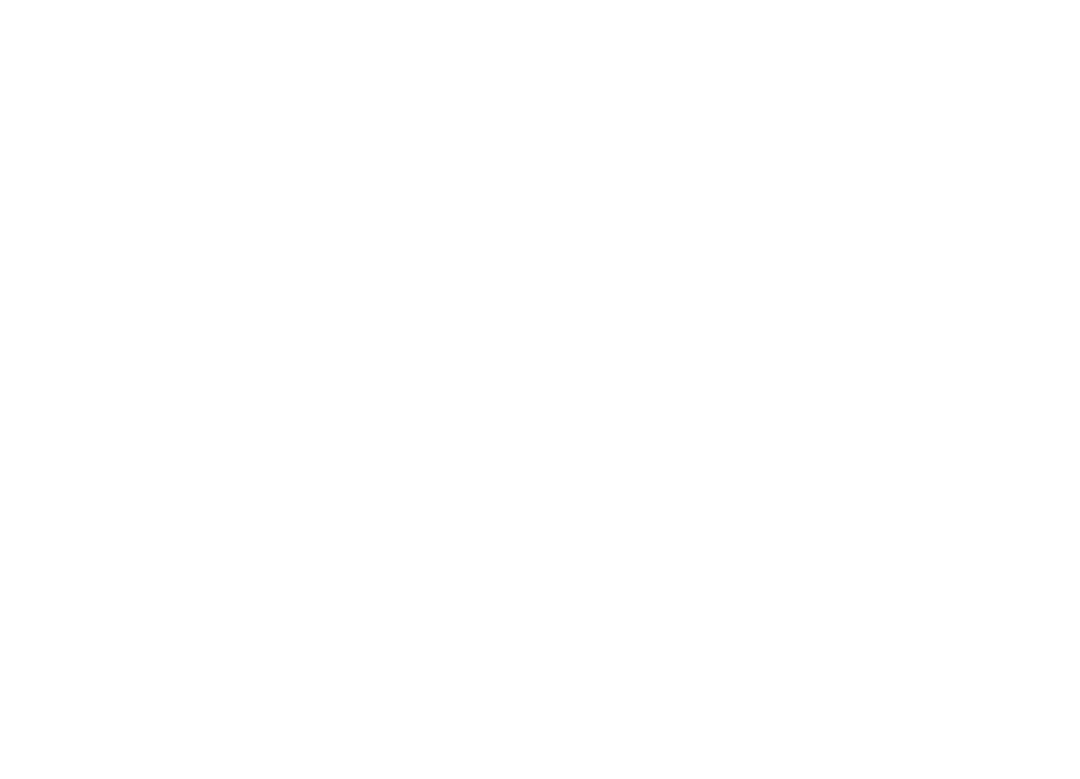

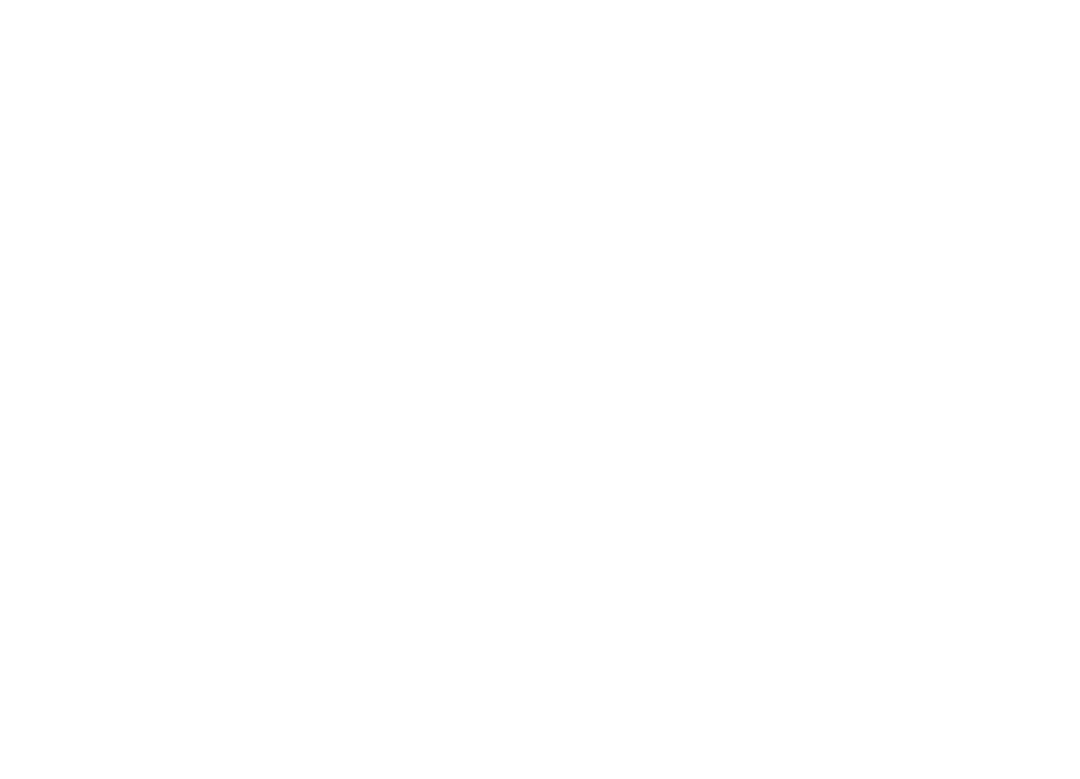

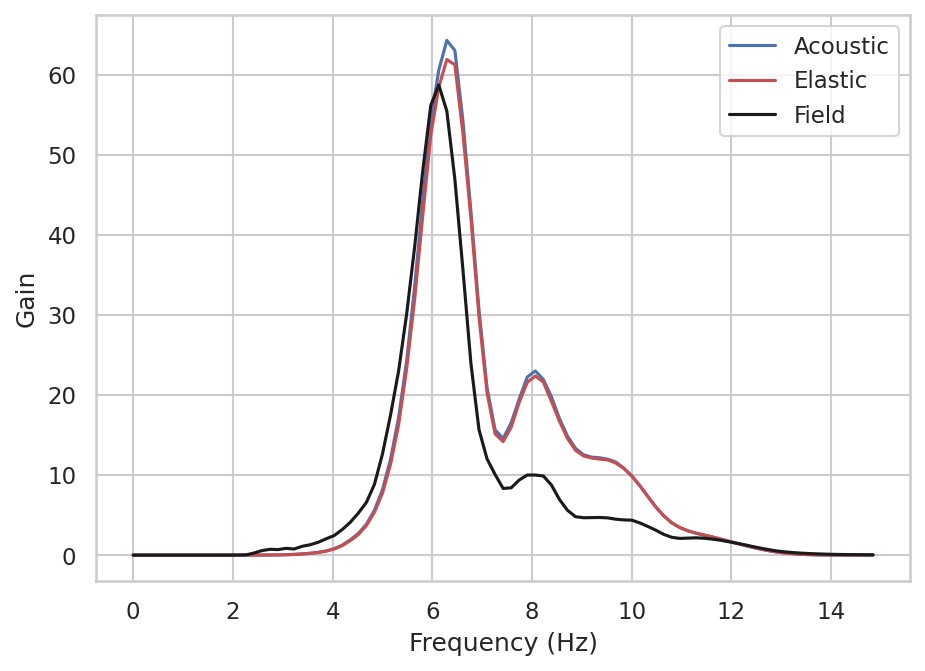

In [290]:
# importlib.reload(vis)
vis.plot_shot(np.concatenate([src_tr_mean_ac, src_tr_mean_el, dst_tr_mean], 0), 
              title='Mean acoustic / elastic / field', colorbar=True,
              dt=d.DT, vmin=-0.01, vmax=0.01)
vis.plot_shot(np.concatenate([src_tr_std_ac, src_tr_std_el, dst_tr_std], 0), 
              title='STD acoustic / elastic / field', dt=d.DT, vmin=-0.1, vmax=0.1)

dictlist = [{'data': src_tr_mean_ac, 'line': 'b', 'label': 'Acoustic'}, 
            {'data': src_tr_mean_el, 'line': 'r', 'label': 'Elastic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)
# vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15, phase=True)

In [291]:
# d_syn.save_folder = './test/'
# d_syn.PHYSICS = 2
# d_syn.forward(api.Model(*make_vp_vs_rho(other_models[12]), dx), src_syn_ac, rec_syn, 'mpirun -np 4')

In [292]:
# shots, fnames = d_syn.get_shots(return_filenames=True)
# vis.plot_shot(np.concatenate(shots, 0), pclip=0.1)

In [293]:
# d_syn.parser_report()

In [294]:
# shots, fnames = d_syn.get_snapshots(return_filenames=True)
# print(len(shots), shots[0].shape)
# vis.plot_shot(shots[1][:, 0, :])

In [295]:
# d_syn.save_folder = './test/'
# d_syn.PHYSICS = 2
# d_syn.NPROCX = 16
# d_syn.NPROCY = 2
# d_syn.DT = d.DT / 8
# d_syn.NT = d.NT * 8

# import scipy
# fine_vp = scipy.ndimage.zoom(other_models[model_id], 4)
# print(fine_vp.shape)
# fine_model = api.Model(*make_vp_vs_rho(fine_vp), dx // 4)
# d_syn.forward(fine_model, src_syn, rec_syn, 'mpirun -np 32')

In [146]:
# shots, fnames = d_syn.get_shots(return_filenames=True)
# vis.plot_shot(np.concatenate(shots, 0), pclip=0.1)

# Create limited datasets extracted from the main one

In [147]:
# # importlib.reload(sd)
# tag = 'ac'
# roots = {'el': root_dataset_syn_filt_el, 'ac': root_dataset_syn_filt_ac}
# for i in [32, 64, 128, 256, 512]:
#     src = roots[tag]
#     dst = roots[tag].replace(f"1024_filt_{tag}_vel", f"{i}_filt_{tag}_vel/")
#     os.makedirs(dst, exist_ok=True)
#     os.makedirs(os.path.join(dst, 'train/raw/'), exist_ok=True)
#     sd.cmd(f'cp -r {os.path.join(src, "test")} {dst}')
#     sd.cmd(f'cp -r {os.path.join(src, "val")} {dst}')
#     rand_models = np.load(os.path.join(src, 'rand_models.npy'))
#     cmd = 'cp ' + src + '/train/raw/model_{0..' + str(i) + '}_* ' + dst + 'train/raw/'
# #     sd.cmd(cmd)

cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel


## (after) ML code was run

Copy previously created cube*.npy files when filtered data < 4 Hz to new folders

In [ ]:
# tag = 'el'
# fmax = '4'
# roots = {'el': root_dataset_syn_filt_el, 'ac': root_dataset_syn_filt_ac}
# for i in [32, 64, 128, 256, 512, 1024]:
#     src = roots[tag].replace(f"_filt_{tag}_1024", f"_filt_{tag}_{i}/")
#     dst = roots[tag].replace(f"_filt_{tag}_1024", f"_filt{fmax}_{tag}_{i}/")
#     os.makedirs(dst, exist_ok=True)
#     sd.cmd(f"cp {os.path.join(src, 'cube*.npy')} {dst}")

Delete that old cube files

In [ ]:
# for i in [32, 64, 128, 256, 512, 1024]:
#     src = roots[tag].replace(f"_filt_{tag}_1024", f"_filt_{tag}_{i}/")
#     sd.cmd(f"rm {os.path.join(src, 'cube*.npy')}")